# 1.Dataset Processing (Model A)

The section immideately below contains all necessray imports.

In [ ]:
import math
import random
import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import spacy
import torchtext
from torchtext.data.metrics import bleu_score
import json

import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


The section immideately below contains token sequence the preprosessing steps

The loading of the Traning, Val, and Testing datasets:

In [ ]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Get the file ID of the JSON file you want to open
test_id = "1PIaL_FR_NKabc-qKIi_RpaRwsoGgaPqw"
train_id = "1o3dgEDYno-d2WYM9w3tFE_8jF8pDYzyU"
val_id = "1TZZO6Pg16dI_flowwryrF0ZKfyBhrHDf"

# Download the file
test = drive.CreateFile({'id': test_id})
test.GetContentFile('test_data.json')
train = drive.CreateFile({'id': train_id})
train.GetContentFile('train_data.json')
val = drive.CreateFile({'id': val_id})
val.GetContentFile('val_data.json')

# Read the downloaded JSON file
with open('test_data.json', 'r') as f:
    test_data = json.load(f)

with open('train_data.json', 'r') as f:
    train_data = json.load(f)

with open('val_data.json', 'r') as f:
    val_data = json.load(f)


def format_rows(data):
    formatted_rows = []
    index = 0
    for row in data:
        sentence = row[0]
        aspect = row[1]
        polarity = row[2]
        formatted_rows.append([index, sentence, aspect, polarity])
        index += 1
    return formatted_rows


rows = test_data['data']
test_data_formatted = format_rows(rows)
rows = train_data['data']
train_data_formatted = format_rows(rows)
rows = val_data['data']
val_data_formatted = format_rows(rows)

print(val_data_formatted[0])

sentences = []
aspects = []
labels = []
for row in test_data_formatted:
  sentences.append(row[1])
  aspects.append(row[2])
  labels.append(row[3])

print(labels)



[0, 'I would wait for a table next time, the food was that good.', 'miscellaneous', 'neutral']
['neutral', 'negative', 'positive', 'negative', 'negative', 'neutral', 'negative', 'neutral', 'neutral', 'negative', 'negative', 'neutral', 'negative', 'neutral', 'positive', 'negative', 'negative', 'neutral', 'negative', 'negative', 'neutral', 'neutral', 'neutral', 'positive', 'negative', 'neutral', 'negative', 'neutral', 'negative', 'neutral', 'neutral', 'positive', 'positive', 'neutral', 'neutral', 'negative', 'neutral', 'positive', 'positive', 'neutral', 'negative', 'neutral', 'neutral', 'negative', 'neutral', 'positive', 'neutral', 'positive', 'neutral', 'positive', 'negative', 'negative', 'neutral', 'positive', 'neutral', 'positive', 'positive', 'negative', 'neutral', 'positive', 'neutral', 'positive', 'neutral', 'positive', 'neutral', 'neutral', 'positive', 'neutral', 'negative', 'negative', 'positive', 'negative', 'neutral', 'negative', 'positive', 'neutral', 'positive', 'neutral', 'n

In [ ]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have",
                    "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us",
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have",
                    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
                    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
                    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}


def pre_process(sent_list):
    output = []
    for sent in sent_list:
        sent = sent.lower() #case-folding
        for word, new_word in contraction_dict.items():
            sent = sent.replace(word, new_word) #dealing with contractions
        sent = re.sub(r'[^\w\s]','',sent) #removing punctuation
        output.append(word_tokenize(sent)) #tokenization
    return output

# Preprocessing the data using the function defined above
input_token_list = pre_process(sentences) # -> input to encoder
label_token_list = pre_process(labels)

input_token_list_n = []
for x in range(len(input_token_list)):
  input_token_list_n.append(input_token_list[x] + ["<HL>"] + [aspects[x]])

print(input_token_list_n)
# Adding special tokens for generation: <BOS> indicates beginning of sentence, <EOS> means end o sentence.
#output_token_list = [["<BOS>"] + s for s in label_token_list] # -> input to decoder during the teacher-forcing training
output_token_list = label_token_list
#target_token_list = [s + ["<EOS>"] for s in label_token_list] # -> ground truth to be compared with the decoder output
target_token_list = label_token_list

[['we', 'went', 'again', 'and', 'sat', 'at', 'the', 'bar', 'this', 'time', 'i', 'had', '5', 'pints', 'of', 'guinness', 'and', 'not', 'one', 'buyback', 'i', 'ordered', 'a', 'basket', 'of', 'onion', 'rings', 'and', 'there', 'were', 'about', '5', 'in', 'the', 'basket', 'the', 'rest', 'was', 'filled', 'with', 'crumbs', 'the', 'chili', 'was', 'not', 'even', 'edible', '<HL>', 'place'], ['we', 'went', 'again', 'and', 'sat', 'at', 'the', 'bar', 'this', 'time', 'i', 'had', '5', 'pints', 'of', 'guinness', 'and', 'not', 'one', 'buyback', 'i', 'ordered', 'a', 'basket', 'of', 'onion', 'rings', 'and', 'there', 'were', 'about', '5', 'in', 'the', 'basket', 'the', 'rest', 'was', 'filled', 'with', 'crumbs', 'the', 'chili', 'was', 'not', 'even', 'edible', '<HL>', 'food'], ['the', 'food', 'was', 'good', 'but', 'it', 'is', 'not', 'worth', 'the', 'waitor', 'the', 'lousy', 'service', '<HL>', 'food'], ['the', 'food', 'was', 'good', 'but', 'it', 'is', 'not', 'worth', 'the', 'waitor', 'the', 'lousy', 'service',

In [ ]:
MAX_LENGTH = max([len(s) for s in input_token_list] + [len(s) for s in target_token_list])
n_data = len(labels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# set up a vocab to index dictionary
word_to_ix = {"<pad>": 0, "<HL>": 1}
for sentence in input_token_list_n+output_token_list:
    for word in sentence:
        if word not in word_to_ix:
          word_to_ix[word] = len(word_to_ix)
word_list = list(word_to_ix.keys())
print(word_to_ix)

label_to_index = {
    "positive": 0,
    "negative": 1,
    "neutral": 2
}

# construct token index lists for input, output and target
# i.e., to convert each sequence into corresponding index based on the index dictionary we created in the previous section
# e.g., ['are', 'your', 'systems', 'functioning'] -> [42, 6, 2576, 2577]
def to_index(data, to_ix):
    input_index_list = []
    for sent in data:
        input_index_list.append([to_ix[w] for w in sent])
    return input_index_list

input_index = to_index(input_token_list_n, word_to_ix)
output_index = to_index(output_token_list, word_to_ix)
target_index = to_index(target_token_list, label_to_index)

def make_batch(data):
    #### TODO: make the cap static and add turncat function
    cap = max(len(lst) for lst in data)
    padded = []
    for x in data:
      if len(x) < cap:
        w = []
        for _ in range(cap-len(x)):
          w.append(0)
        padded.append(x + w)
      else:
        padded.append(x)

    padded = torch.tensor(padded)

    return padded.to(device)

input = make_batch(input_index)
output = make_batch(output_index)
#target = make_batch(target_index)


def get_batch(ipt, lbl, i):
    seq_len = min(bptt, len(ipt) - 1 - i)
    data = ipt[i:i+seq_len]
    target = lbl[i:i+seq_len]
    return data, target

print(input)

{'<pad>': 0, '<HL>': 1, 'we': 2, 'went': 3, 'again': 4, 'and': 5, 'sat': 6, 'at': 7, 'the': 8, 'bar': 9, 'this': 10, 'time': 11, 'i': 12, 'had': 13, '5': 14, 'pints': 15, 'of': 16, 'guinness': 17, 'not': 18, 'one': 19, 'buyback': 20, 'ordered': 21, 'a': 22, 'basket': 23, 'onion': 24, 'rings': 25, 'there': 26, 'were': 27, 'about': 28, 'in': 29, 'rest': 30, 'was': 31, 'filled': 32, 'with': 33, 'crumbs': 34, 'chili': 35, 'even': 36, 'edible': 37, 'place': 38, 'food': 39, 'good': 40, 'but': 41, 'it': 42, 'is': 43, 'worth': 44, 'waitor': 45, 'lousy': 46, 'service': 47, 'waiter': 48, 'took': 49, 'our': 50, 'drink': 51, 'order': 52, 'then': 53, 'did': 54, 'see': 55, 'him': 56, 'for': 57, '15': 58, 'minutes': 59, 'staff': 60, 'miscellaneous': 61, 'does': 62, 'get': 63, 'crowded': 64, 'plenty': 65, 'blue': 66, 'shirted': 67, 'cigar': 68, 'smoking': 69, 'wannabes': 70, 'so': 71, 'make': 72, 'reservation': 73, 'after': 74, 'hearing': 75, 'all': 76, 'specials': 77, 'you': 78, 'would': 79, 'think':

# 2. Model Implementation (Model A)

Hyperparameters

In [ ]:
INPUT_SIZE = len(word_to_ix)  # source vocab size
OUTPUT_SIZE = 3  # target vocab size
HIDDEN_SIZE = 512
N_LAYERS = 1
N_HEADS = 8
FF_SIZE = 2048
DROPOUT_RATE = 0.1
CLIP = 1
lr = 0.005
N_EPOCHS = 25
batch_size = input.size(1)
bptt = batch_size
print(batch_size)

66


Scaled Dot Product Attention

In [ ]:
class ScaledDotProductAttention(nn.Module):
    """ Computes scaled dot product attention
    """

    def __init__(self, scale, dropout_rate):
        super(ScaledDotProductAttention, self).__init__()
        self.scale = scale
        self.dropout_rate = dropout_rate

        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, query, key, value, mask=None):
        """ query: (batch_size, n_heads, query_len, head_dim)
            key: (batch_size, n_heads, key_len, head_dim)
            value: (batch_size, n_heads, value_len, head_dim)
            mask: (batch_size, 1, 1, source_seq_len) for source mask
                  (batch_size, 1, target_seq_len, target_seq_len) for target mask
        """
        # calculate alignment scores
        scores = torch.matmul(query, key.transpose(-2, -1))  # (batch_size, n_heads, query_len, value_len)
        scores = scores / self.scale  # (batch_size, num_heads, query_len, value_len)

        # mask out invalid positions
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))  # (batch_size, n_heads, query_len, value_len)

        # calculate the attention weights (prob) from alignment scores
        attn_probs = F.softmax(scores, dim=-1)  # (batch_size, n_heads, query_len, value_len)

        # calculate context vector
        output = torch.matmul(self.dropout(attn_probs), value)  # (batch_size, n_heads, query_len, head_dim)

        # output: (batch_size, n_heads, query_len, head_dim)
        # attn_probs: (batch_size, n_heads, query_len, value_len)
        return output, attn_probs

Multi-head Attention

In [ ]:
class MultiHeadAttention(nn.Module):
    """ Implements Multi-Head Self-Attention proposed by Vaswani et al., 2017.
        refer https://arxiv.org/abs/1706.03762
    """

    def __init__(self, d_model, n_heads, dropout_rate=0.1):
        super(MultiHeadAttention, self).__init__()
        assert d_model % n_heads == 0, "`d_model` should be a multiple of `n_heads`"

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = self.d_v = d_model // n_heads  # head_dim
        self.dropout_rate = dropout_rate

        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model)

        self.attention = ScaledDotProductAttention(np.sqrt(self.d_k), dropout_rate)


    def split_heads(self, x):
        """ x: (batch_size, seq_len, d_model)
        """
        batch_size = x.size(0)
        x = x.view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)  # (batch_size, n_heads, seq_len, d_k)

        # x: (batch_size, n_heads, seq_len, head_dim)
        return x


    def group_heads(self, x):
        """ x: (batch_size, n_heads, seq_len, head_dim)
        """
        batch_size = x.size(0)
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.n_heads * self.d_k)

        # x: (batch_size, seq_len, d_model)
        return x


    def forward(self, query, key, value, mask=None):
        """ query: (batch_size, query_len, d_model)
            key: (batch_size, key_len, d_model)
            value: (batch_size, value_len, d_model)
            mask: (batch_size, 1, source_seq_len) for source mask
                  (batch_size, target_seq_len, target_seq_len) for target mask
        """
        # apply linear projections to query, key and value
        Q = self.split_heads(self.W_q(query))  # (batch_size, n_heads, query_len, head_dim)
        K = self.split_heads(self.W_k(key))  # (batch_size, n_heads, key_len, head_dim)
        V = self.split_heads(self.W_v(value))  # (batch_size, n_heads, value_len, head_dim)

        if mask is not None:
            # apply same mask for all the heads
            mask = mask.unsqueeze(1)

            # mask: (batch_size, 1, 1, source_seq_len) for source mask
            #       (batch_size, 1, target_seq_len, target_seq_len) for target mask

        # calculate attention weights and context vector for each of the heads
        x, attn = self.attention(Q, K, V, mask)

        # x: (batch_size, n_heads, query_len, head_dim)
        # attn: (batch_size, n_heads, query_len, value_len)

        # concatenate context vector of all the heads
        x = self.group_heads(x)  # (batch_size, query_len, d_model)

        # apply linear projection to concatenated context vector
        x = self.W_o(x)  # (batch_size, query_len, d_model)

        # x: (batch_size, query_len, d_model)
        # attn: (batch_size, n_heads, query_len, value_len)
        return x, attn

Positional Encoding

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, vocab_size=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(vocab_size, d_model)
        position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float()
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)

Position-wise FF Network

In [ ]:
class PositionwiseFeedForward(nn.Module):
    """ Implements a two layer feed-forward network.
    """

    def __init__(self, d_model, d_ff, dropout_rate=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff
        self.dropout_rate = dropout_rate

        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, x):
        """ x: (batch_size, seq_len, d_model)
        """
        x = self.dropout(F.relu(self.w_1(x)))  # (batch_size, seq_len, d_ff)
        x = self.w_2(x)  # (batch_size, seq_len, d_model)

        # x: (batch_size, seq_len, d_model)
        return x

Encoder

In [ ]:
class EncoderLayer(nn.Module):
    """ Encoder is made up of a self-attention layer and a feed-forward layer.
    """

    def __init__(self, d_model, n_heads, d_ff, dropout_rate=0.1):
        super(EncoderLayer, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff
        self.n_heads = n_heads
        self.dropout_rate = dropout_rate

        self.attn_layer = MultiHeadAttention(d_model, n_heads, dropout_rate)
        self.attn_layer_norm = nn.LayerNorm(d_model, eps=1e-6)

        self.ff_layer = PositionwiseFeedForward(d_model, d_ff, dropout_rate)
        self.ff_layer_norm = nn.LayerNorm(d_model, eps=1e-6)

        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, x, mask):
        """ x: (batch_size, source_seq_len, d_model)
            mask: (batch_size, 1, source_seq_len)
        """
        # apply self-attention
        x1, _ = self.attn_layer(x, x, x, mask)  # (batch_size, source_seq_len, d_model)

        # apply residual connection followed by layer normalization
        x = self.attn_layer_norm(x + self.dropout(x1))  # (batch_size, source_seq_len, d_model)

        # apply position-wise feed-forward
        x1 = self.ff_layer(x)  # (batch_size, source_seq_len, d_model)

        # apply residual connection followed by layer normalization
        x = self.ff_layer_norm(x + self.dropout(x1))  # (batch_size, source_seq_len, d_model)

        # x: (batch_size, source_seq_len, d_model)
        return x

In [ ]:
class Encoder(nn.Module):
    """ Encoder block is a stack of N identical encoder layers.
    """

    def __init__(self, vocab_size, d_model, n_layers, n_heads, d_ff, pad_idx, dropout_rate=0.1, max_len=5000):
        super(Encoder, self).__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_layers = n_layers
        self.d_ff = d_ff
        self.pad_idx = pad_idx
        self.dropout_rate = dropout_rate
        self.max_len = max_len

        self.tok_embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.pos_embedding = PositionalEncoding(d_model, dropout_rate, max_len)
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, n_heads, d_ff, dropout_rate)
            for _ in range(n_layers)
        ])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)


    def forward(self, x, mask):
        """ x: (batch_size, source_seq_len)
            mask: (batch_size, 1, source_seq_len)
        """
        # apply positional encoding to token sequences
        x = self.tok_embedding(x)  # (batch_size, source_seq_len, d_model)
        x = self.pos_embedding(x)  # (batch_size, source_seq_len, d_model)

        for layer in self.layers:
            x = layer(x, mask)  # (batch_size, source_seq_len, d_model)

        x = self.layer_norm(x)  # (batch_size, source_seq_len, d_model)

        # x: (batch_size, source_seq_len, d_model)
        return x

Decoder

In [ ]:
class DecoderLayer(nn.Module):
    """ Decoder is made up of a self-attention layer, a encoder-decoder attention layer and a feed-forward layer. """
    def __init__(self, d_model, n_heads, d_ff, dropout_rate=0.1, num_classes=None):
        super(DecoderLayer, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff
        self.n_heads = n_heads
        self.dropout_rate = dropout_rate
        self.attn_layer = MultiHeadAttention(d_model, n_heads, dropout_rate)
        self.attn_layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.enc_attn_layer = MultiHeadAttention(d_model, n_heads, dropout_rate)
        self.enc_attn_layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.ff_layer = PositionwiseFeedForward(d_model, d_ff, dropout_rate)
        self.ff_layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.dropout = nn.Dropout(dropout_rate)

        # Classification layer
        self.num_classes = num_classes
        if self.num_classes is not None:
            self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x, memory, src_mask):
        """ x: (batch_size, target_seq_len, d_model)
        memory: (batch_size, source_seq_len, d_model)
        src_mask: (batch_size, 1, source_seq_len)
        tgt_mask: (batch_size, target_seq_len, target_seq_len) """
        # apply self-attention
        x1, _ = self.attn_layer(x, x, x)
        # (batch_size, target_seq_len, d_model)
        # apply residual connection followed by layer normalization
        x = self.attn_layer_norm(x + self.dropout(x1))
        # (batch_size, target_seq_len, d_model)

        # apply encoder-decoder attention
        # memory is the output from encoder block (encoder states)
        x1, attn = self.enc_attn_layer(x, memory, memory, src_mask)
        # x1: (batch_size, target_seq_len, d_model)
        # attn: (batch_size, n_heads, target_seq_len, source_seq_len)
        # apply residual connection followed by layer normalization
        x = self.enc_attn_layer_norm(x + self.dropout(x1))
        # (batch_size, target_seq_len, d_model)

        # apply position-wise feed-forward
        x1 = self.ff_layer(x)
        # (batch_size, target_seq_len, d_model)
        # apply residual connection followed by layer normalization
        x = self.ff_layer_norm(x + self.dropout(x1))
        # (batch_size, target_seq_len, d_model)

        # x: (batch_size, target_seq_len, d_model) or (batch_size, num_classes)
        # attn: (batch_size, n_heads, target_seq_len, source_seq_len)
        return x, attn

In [ ]:
class Decoder(nn.Module):
    """ Decoder block is a stack of N identical decoder layers.
    """

    def __init__(self, vocab_size, d_model, n_layers, n_heads, d_ff, pad_idx, dropout_rate=0.1, max_len=5000):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_layers = n_layers
        self.d_ff = d_ff
        self.pad_idx = pad_idx
        self.dropout_rate = dropout_rate
        self.max_len = max_len

        self.tok_embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.pos_embedding = PositionalEncoding(d_model, dropout_rate, max_len)
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, n_heads, d_ff, dropout_rate)
            for _ in range(n_layers)
        ])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)


    def forward(self, x, memory, src_mask):
        """ x: (batch_size, target_seq_len, d_model)
            memory: (batch_size, source_seq_len, d_model)
            src_mask: (batch_size, 1, source_seq_len)
            tgt_mask: (batch_size, target_seq_len, target_seq_len)
        """

        #print("Input tensor x:", x)
        #print("tok_embedding weight size:", self.tok_embedding.weight.size(0))

        # apply positional encoding to token sequences
        x = self.tok_embedding(x)  # (batch_size, target_seq_len, d_model)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

        for layer in self.layers:
            x, attn = layer(x, memory, src_mask)  # (batch_size, target_seq_len, d_model)

        x = self.layer_norm(x)  # (batch_size, target_seq_len, d_model)

        # x: (batch_size, target_seq_len, d_model)
        # attn: (batch_size, n_heads, target_seq_len, source_seq_len)
        return x, attn

In [ ]:
class Transformer(nn.Module):
    """ Transformer wrapper for encoder and decoder for classification. """
    def __init__(self, encoder, decoder, num_classes, pad_idx, d_model):
        super(Transformer, self).__init__()
        self.pad_idx = pad_idx
        self.encoder = encoder
        self.decoder = decoder
        self.num_classes = num_classes
        self.fc_out = nn.Linear(d_model, self.num_classes)

    def get_pad_mask(self, x, pad_idx):
        """ x: (batch_size, seq_len) """
        x = (x != pad_idx).unsqueeze(-2)  # (batch_size, 1, seq_len)
        return x

    def get_subsequent_mask(self, x):
        """ x: (batch_size, seq_len) """
        seq_len = x.size(1)
        subsequent_mask = np.triu(np.ones((1, seq_len, seq_len)), k=1).astype(np.int8)
        subsequent_mask = (torch.from_numpy(subsequent_mask) == 0).to(x.device)
        return subsequent_mask

    def forward(self, src, tgt):
        """ src: (batch_size, source_seq_len)
        tgt: (batch_size, target_seq_len) """
        src_mask = self.get_pad_mask(src, self.pad_idx)
        #tgt_mask = self.get_pad_mask(tgt, self.pad_idx) & self.get_subsequent_mask(tgt)
        enc_output = self.encoder(src, src_mask)
        dec_output, _ = self.decoder(tgt, enc_output, src_mask)

        # Classification
        classification_output = dec_output[:, -1, :]  # Take the final output representation
        classification_output = self.fc_out(classification_output)  # Apply a linear layer
        #classification_output = nn.functional.softmax(classification_output, dim=-1)  # Apply softmax

        # classification_output: (batch_size, num_classes)
        return classification_output

Training

In [ ]:
PAD_IDX = 0
encoder = Encoder(INPUT_SIZE, HIDDEN_SIZE, N_LAYERS, N_HEADS, FF_SIZE, PAD_IDX, DROPOUT_RATE)
decoder = Decoder(INPUT_SIZE, HIDDEN_SIZE, N_LAYERS, N_HEADS, FF_SIZE, PAD_IDX, DROPOUT_RATE)

model = Transformer(encoder, decoder, OUTPUT_SIZE, PAD_IDX, HIDDEN_SIZE).to(device)

NTOKENS:  2006
torch.Size([66, 66]) torch.Size([66, 1])
tensor(False) tensor(False)
tensor(False) tensor(False)
torch.Size([66, 66]) torch.Size([66, 1])
tensor(False) tensor(False)
tensor(False) tensor(False)
torch.Size([66, 66]) torch.Size([66, 1])
tensor(False) tensor(False)
tensor(False) tensor(False)
torch.Size([66, 66]) torch.Size([66, 1])
tensor(False) tensor(False)
tensor(False) tensor(False)
torch.Size([66, 66]) torch.Size([66, 1])
tensor(False) tensor(False)
tensor(False) tensor(False)
torch.Size([66, 66]) torch.Size([66, 1])
tensor(False) tensor(False)
tensor(False) tensor(False)
torch.Size([66, 66]) torch.Size([66, 1])
tensor(False) tensor(False)
tensor(False) tensor(False)
torch.Size([66, 66]) torch.Size([66, 1])
tensor(False) tensor(False)
tensor(False) tensor(False)
torch.Size([66, 66]) torch.Size([66, 1])
tensor(False) tensor(False)
tensor(False) tensor(False)
torch.Size([66, 66]) torch.Size([66, 1])
tensor(False) tensor(False)
tensor(False) tensor(False)
torch.Size([66,

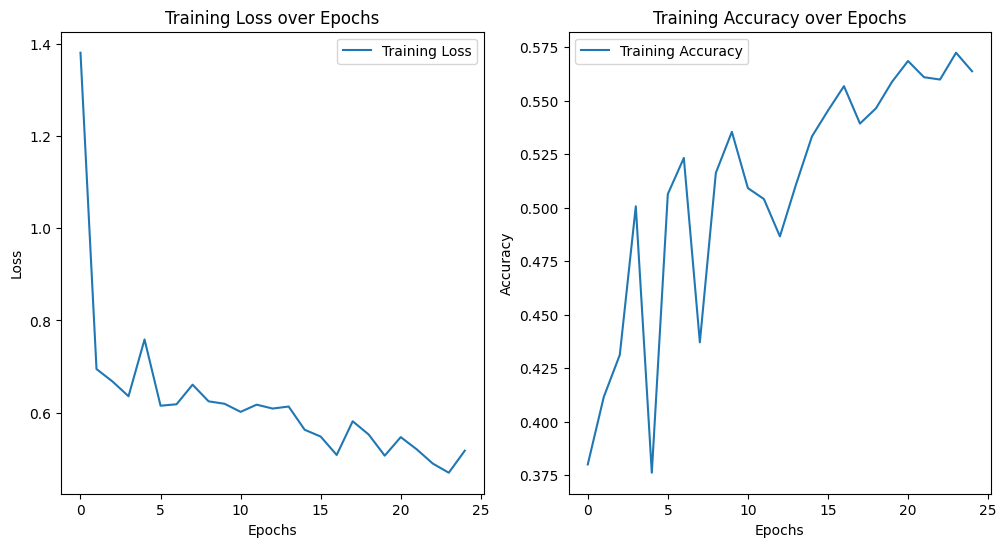

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

import time

losses = []
accuracies = []

def calculate_accuracy(output, targets):
    predictions = output.argmax(dim=1, keepdim=True)  # assuming your output includes class scores
    correct = predictions.eq(targets.view_as(predictions)).sum().item()
    return correct / len(targets)


def train():
    model.train() # Turn on the train mode
    ntokens = len(word_to_ix)
    print("NTOKENS: ", ntokens)
    for epoch in range(1, N_EPOCHS + 1):
      total_loss = 0.0
      total_accuracy = 0.0
      for batch, i in enumerate(range(0, input.size(0) - 1, bptt)):
        data, targets = get_batch(input, torch.tensor(target_index), i)
        print(data.size(), targets.size())
        print(torch.isnan(data).any(), torch.isinf(data).any())
        print(torch.isnan(targets).any(), torch.isinf(targets).any())

        optimizer.zero_grad()
        output = model(data, data)
        for name, param in model.named_parameters():
          if not torch.isfinite(param).all():
            print(f"Parameter {name} contains nan or inf.")
        if not torch.isfinite(output).all():
          print("Output contains nan or inf.")
        if not torch.isfinite(targets).all():
          print("Targets contain nan or inf.")
        #print("OPTSIZE: ", output.size())
        #print(output.view(-1, output.size(-1)).size(), targets.view(-1).size())
        loss = criterion(output.view(-1, output.size(-1)), targets.view(-1))
        #print(loss)
        loss.backward()
        w = torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        #print(w)
        optimizer.step()

        total_loss += loss.item()
        total_accuracy += calculate_accuracy(output, targets)

      avg_loss = total_loss / len(range(0, input.size(0) - 1, bptt))
      avg_accuracy = total_accuracy / len(range(0, input.size(0) - 1, bptt))
      losses.append(avg_loss)
      accuracies.append(avg_accuracy)
      print(f"Epoch {epoch}: Loss = {avg_loss}, Accuracy = {avg_accuracy}")

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(losses, label='Training Loss')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Training Accuracy')
    plt.title('Training Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


train()

# 3.Testing and Evaluation (Model A)

# 1. Dataset Processing (Model B)

The section immideately below contains all necessray imports.

In [ ]:
import math
import random
import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import spacy
import torchtext
from torchtext.data.metrics import bleu_score
import json

import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Get the file ID of the JSON file you want to open
test_id = "1PIaL_FR_NKabc-qKIi_RpaRwsoGgaPqw"
train_id = "1o3dgEDYno-d2WYM9w3tFE_8jF8pDYzyU"
val_id = "1TZZO6Pg16dI_flowwryrF0ZKfyBhrHDf"

# Download the file
test = drive.CreateFile({'id': test_id})
test.GetContentFile('test_data.json')
train = drive.CreateFile({'id': train_id})
train.GetContentFile('train_data.json')
val = drive.CreateFile({'id': val_id})
val.GetContentFile('val_data.json')

# Read the downloaded JSON file
with open('test_data.json', 'r') as f:
    test_data = json.load(f)

with open('train_data.json', 'r') as f:
    train_data = json.load(f)

with open('val_data.json', 'r') as f:
    val_data = json.load(f)


def format_rows(data):
    formatted_rows = []
    index = 0
    for row in data:
        sentence = row[0]
        aspect = row[1]
        polarity = row[2]
        formatted_rows.append([index, sentence, aspect, polarity])
        index += 1
    return formatted_rows


rows = test_data['data']
test_data_formatted = format_rows(rows)
rows = train_data['data']
train_data_formatted = format_rows(rows)
rows = val_data['data']
val_data_formatted = format_rows(rows)

print(val_data_formatted[0])

sentences = []
aspects = []
labels = []
for row in test_data_formatted:
  sentences.append(row[1])
  aspects.append(row[2])
  labels.append(row[3])

print(aspects)

In [ ]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have",
                    "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us",
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have",
                    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
                    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
                    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

def generate_ngrams(sents, n, aspect):
    ngram_list = []
    x = 0
    for sent in sents:
        if len(sent) < n:
            print("TRIGGER")
            continue  # Skip sentences shorter than `n`
        ngrams = [sent[i:i + n] for i in range(len(sent) - n + 1)]
        for item in ngrams:
          item.append(aspect[x])
        ngram_list.append(ngrams)
        x += 1
    return ngram_list

def pre_process(sent_list, aspect):
    output = []
    for sent in sent_list:
        sent = sent.lower() #case-folding
        for word, new_word in contraction_dict.items():
            sent = sent.replace(word, new_word) #dealing with contractions
        sent = re.sub(r'[^\w\s]','',sent) #removing punctuation
        output.append(word_tokenize(sent)) #tokenization

    return generate_ngrams(output, 6, aspect)

def pre_process_decoder(sent_list):
    output = []
    for sent in sent_list:
        sent = sent.lower() #case-folding
        for word, new_word in contraction_dict.items():
            sent = sent.replace(word, new_word) #dealing with contractions
        sent = re.sub(r'[^\w\s]','',sent) #removing punctuation
        output.append(word_tokenize(sent)) #tokenization

    return output

# Preprocessing the data using the function defined above
input_token_list_decoder = pre_process_decoder(sentences) # -> input to encoder

# Preprocessing the data using the function defined above
input_token_list = pre_process(sentences, aspects) # -> input to encoder
label_token_list = pre_process_decoder(labels)
print(input_token_list, label_token_list)
print(len(input_token_list), len(label_token_list))

target_token_list = label_token_list

In [ ]:
#MAX_LENGTH = max([len(s) for s in input_token_list] + [len(s) for s in target_token_list])
#n_data = len(labels)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# set up a vocab to index dictionary
word_to_ix = {"<pad>": 0}
for module in input_token_list:
  for sentence in module:
    for word in sentence:
        if word not in word_to_ix:
          word_to_ix[word] = len(word_to_ix)
word_list = list(word_to_ix.keys())
print(word_to_ix)
print(len(word_to_ix))

label_to_index = {
    "positive": 0,
    "negative": 1,
    "neutral": 2
}

# construct token index lists for input, output and target
# i.e., to convert each sequence into corresponding index based on the index dictionary we created in the previous section
# e.g., ['are', 'your', 'systems', 'functioning'] -> [42, 6, 2576, 2577]
def to_index_T(data, to_ix):
    ground_truth = []
    for sent in data:
        ground_truth.append([to_ix[w] for w in sent])
    return ground_truth

def to_index_I(data, to_ix):
    input_index_list = []
    for sent in data:
      buffer = []
      for seq in sent:
        buffer.append([to_ix[w] for w in seq])
      input_index_list.append(buffer)
    return input_index_list

input_index = to_index_I(input_token_list, word_to_ix)
print(input_index)
input_index_decoder = to_index_T(input_token_list_decoder, word_to_ix)
target_index = to_index_T(target_token_list, label_to_index)

def make_batch(data):
    #### TODO: make the cap static and add turncat function
    cap_ext = max(len(lst) for lst in data)
    cap_int = []
    for x in data:
      cap_int.append(max(len(lst) for lst in x))
    cap_int = max(cap_int)
    print(cap_int, cap_ext)

    opt = []
    for module in data:
      if len(module) < cap_ext:
        w = []
        for _ in range(cap_ext-len(module)):
          w.append([0, 0])
        opt.append(module + w)
      else:
        opt.append(module)

    #print(opt[0])

    padded = []
    for module in opt:
      buffer = []
      for x in module:
        if len(x) < cap_int:
          w = []
          for _ in range(cap_int-len(x)):
            w.append(0)
          buffer.append(x + w)
        else:
          buffer.append(x)
      padded.append(buffer)

    #print(padded[0])
    padded = torch.tensor(padded)

    return padded.to(device)

input = make_batch(input_index)

def make_batch_decoder(data):
    #### TODO: make the cap static and add turncat function
    cap = max(len(lst) for lst in data)
    padded = []
    for x in data:
      if len(x) < cap:
        w = []
        for _ in range(cap-len(x)):
          w.append(0)
        padded.append(x + w)
      else:
        padded.append(x)

    padded = torch.tensor(padded)

    return padded.to(device)

input_decoder = make_batch_decoder(input_index_decoder)

def get_batch(ipt, lbl, i):
    seq_len = min(bptt, len(ipt) - 1 - i)
    data = ipt[i:i+seq_len]
    target = lbl[i:i+seq_len]
    return data, target

print(input.size())
print(input_decoder.size())

# 2. Model Implementation (Model B)

In [ ]:
INPUT_SIZE = len(word_to_ix)  # source vocab size
OUTPUT_SIZE = 3  # target vocab size
HIDDEN_SIZE = 512
N_LAYERS = 1
N_encoder_LAYERS = 1
N_HEADS = 8
FF_SIZE = 2048
DROPOUT_RATE = 0.1
CLIP = 1
lr = 0.005
N_EPOCHS = 25
batch_size = input.size(1)
bptt = batch_size
print(batch_size)

In [ ]:
class ScaledDotProductAttention(nn.Module):
    """ Computes scaled dot product attention
    """

    def __init__(self, scale, dropout_rate):
        super(ScaledDotProductAttention, self).__init__()
        self.scale = scale
        self.dropout_rate = dropout_rate

        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, query, key, value, mask=None):
        """ query: (batch_size, n_heads, query_len, head_dim)
            key: (batch_size, n_heads, key_len, head_dim)
            value: (batch_size, n_heads, value_len, head_dim)
            mask: (batch_size, 1, 1, source_seq_len) for source mask
                  (batch_size, 1, target_seq_len, target_seq_len) for target mask
        """
        # calculate alignment scores
        scores = torch.matmul(query, key.transpose(-2, -1))  # (batch_size, n_heads, query_len, value_len)
        scores = scores / self.scale  # (batch_size, num_heads, query_len, value_len)

        # mask out invalid positions
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))  # (batch_size, n_heads, query_len, value_len)

        # calculate the attention weights (prob) from alignment scores
        attn_probs = F.softmax(scores, dim=-1)  # (batch_size, n_heads, query_len, value_len)

        # calculate context vector
        output = torch.matmul(self.dropout(attn_probs), value)  # (batch_size, n_heads, query_len, head_dim)

        # output: (batch_size, n_heads, query_len, head_dim)
        # attn_probs: (batch_size, n_heads, query_len, value_len)
        return output, attn_probs

In [ ]:
class MultiHeadAttention(nn.Module):

    def __init__(self, d_model, n_heads, dropout_rate=0.1):
        super(MultiHeadAttention, self).__init__()
        assert d_model % n_heads == 0, "`d_model` should be a multiple of `n_heads`"

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = self.d_v = d_model // n_heads  # head_dim
        self.dropout_rate = dropout_rate

        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model)

        self.attention = ScaledDotProductAttention(np.sqrt(self.d_k), dropout_rate)


    def split_heads(self, x):
        """ x: (batch_size, seq_len, d_model)
        """
        batch_size = x.size(0)
        x = x.view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)  # (batch_size, n_heads, seq_len, d_k)

        # x: (batch_size, n_heads, seq_len, head_dim)
        return x


    def group_heads(self, x):
        """ x: (batch_size, n_heads, seq_len, head_dim)
        """
        batch_size = x.size(0)
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.n_heads * self.d_k)

        # x: (batch_size, seq_len, d_model)
        return x


    def forward(self, query, key, value, mask=None):
        """ query: (batch_size, query_len, d_model)
            key: (batch_size, key_len, d_model)
            value: (batch_size, value_len, d_model)
            mask: (batch_size, 1, source_seq_len) for source mask
                  (batch_size, target_seq_len, target_seq_len) for target mask
        """
        # apply linear projections to query, key and value
        Q = self.split_heads(self.W_q(query))  # (batch_size, n_heads, query_len, head_dim)
        K = self.split_heads(self.W_k(key))  # (batch_size, n_heads, key_len, head_dim)
        V = self.split_heads(self.W_v(value))  # (batch_size, n_heads, value_len, head_dim)

        if mask is not None:
            # apply same mask for all the heads
            mask = mask.unsqueeze(1)

            # mask: (batch_size, 1, 1, source_seq_len) for source mask
            #       (batch_size, 1, target_seq_len, target_seq_len) for target mask

        # calculate attention weights and context vector for each of the heads
        x, attn = self.attention(Q, K, V, mask)

        # x: (batch_size, n_heads, query_len, head_dim)
        # attn: (batch_size, n_heads, query_len, value_len)

        # concatenate context vector of all the heads
        x = self.group_heads(x)  # (batch_size, query_len, d_model)

        # apply linear projection to concatenated context vector
        x = self.W_o(x)  # (batch_size, query_len, d_model)

        # x: (batch_size, query_len, d_model)
        # attn: (batch_size, n_heads, query_len, value_len)
        return x, attn

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, vocab_size=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(vocab_size, d_model)
        position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float()
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)

In [ ]:
class PositionwiseFeedForward(nn.Module):
    """ Implements a two layer feed-forward network.
    """

    def __init__(self, d_model, d_ff, dropout_rate=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff
        self.dropout_rate = dropout_rate

        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, x):
        """ x: (batch_size, seq_len, d_model)
        """
        x = self.dropout(F.relu(self.w_1(x)))  # (batch_size, seq_len, d_ff)
        x = self.w_2(x)  # (batch_size, seq_len, d_model)

        # x: (batch_size, seq_len, d_model)
        return x

In [ ]:
class EncoderLayer(nn.Module):
    """ Encoder is made up of a self-attention layer and a feed-forward layer.
    """

    def __init__(self, d_model, n_heads, d_ff, dropout_rate=0.1):
        super(EncoderLayer, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff
        self.n_heads = n_heads
        self.dropout_rate = dropout_rate

        self.attn_layer = MultiHeadAttention(d_model, n_heads, dropout_rate)
        self.attn_layer_norm = nn.LayerNorm(d_model, eps=1e-6)

        self.ff_layer = PositionwiseFeedForward(d_model, d_ff, dropout_rate)
        self.ff_layer_norm = nn.LayerNorm(d_model, eps=1e-6)

        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, x):
        """ x: (batch_size, source_seq_len, d_model)
            mask: (batch_size, 1, source_seq_len)
        """
        # apply self-attention
        x1, _ = self.attn_layer(x, x, x)  # (batch_size, source_seq_len, d_model)

        # apply residual connection followed by layer normalization
        x = self.attn_layer_norm(x + self.dropout(x1))  # (batch_size, source_seq_len, d_model)

        # apply position-wise feed-forward
        x1 = self.ff_layer(x)  # (batch_size, source_seq_len, d_model)

        # apply residual connection followed by layer normalization
        x = self.ff_layer_norm(x + self.dropout(x1))  # (batch_size, source_seq_len, d_model)

        # x: (batch_size, source_seq_len, d_model)
        return x

In [ ]:
class CrossAttentionEncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout_rate=0.1):
        super(CrossAttentionEncoderLayer, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff
        self.n_heads = n_heads
        self.dropout_rate = dropout_rate

        self.attn_layer = MultiHeadAttention(d_model, n_heads, dropout_rate)
        self.attn_layer_norm = nn.LayerNorm(d_model, eps=1e-6)

        self.ff_layer = PositionwiseFeedForward(d_model, d_ff, dropout_rate)
        self.ff_layer_norm = nn.LayerNorm(d_model, eps=1e-6)

        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, x):
        # apply self-attention
        x1, _ = self.attn_layer(x, x, x)  # (batch_size, source_seq_len, d_model)

        # apply residual connection followed by layer normalization
        x = self.attn_layer_norm(x + self.dropout(x1))  # (batch_size, source_seq_len, d_model)

        # apply position-wise feed-forward
        x1 = self.ff_layer(x)  # (batch_size, source_seq_len, d_model)

        # apply residual connection followed by layer normalization
        x = self.ff_layer_norm(x + self.dropout(x1))  # (batch_size, source_seq_len, d_model)

        # x: (batch_size, source_seq_len, d_model)
        return x

In [ ]:
class CrossAttentionEncoder(nn.Module):
    def __init__(self, vocab_size, d_model, n_encoder_layers, n_heads, d_ff, pad_idx, dropout_rate=0.1, max_len=5000):
        super(CrossAttentionEncoder, self).__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_encoder_layers = n_encoder_layers
        self.d_ff = d_ff
        self.pad_idx = pad_idx
        self.dropout_rate = dropout_rate
        self.max_len = max_len
        self.layers = nn.ModuleList([
            CrossAttentionEncoderLayer(d_model, n_heads, d_ff, dropout_rate)
            for _ in range(n_encoder_layers)
        ])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)


    def forward(self, x):
        for layer in self.layers:
            x = layer(x)  # (batch_size, source_seq_len, d_model)

        x = self.layer_norm(x)  # (batch_size, source_seq_len, d_model)

        # x: (batch_size, source_seq_len, d_model)
        return x

In [ ]:
class Encoder(nn.Module):
    """ Encoder block is a stack of N identical encoder layers.
    """

    def __init__(self, vocab_size, d_model, n_encoder_layers, n_heads, d_ff, pad_idx, dropout_rate=0.1, max_len=5000):
        super(Encoder, self).__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_encoder_layers = n_encoder_layers
        self.d_ff = d_ff
        self.pad_idx = pad_idx
        self.dropout_rate = dropout_rate
        self.max_len = max_len

        self.tok_embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.pos_embedding = PositionalEncoding(d_model, dropout_rate, max_len)
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, n_heads, d_ff, dropout_rate)
            for _ in range(n_encoder_layers)
        ])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)


    def forward(self, x):
        """ x: (batch_size, source_seq_len)
            mask: (batch_size, 1, source_seq_len)
        """
        # apply positional encoding to token sequences
        x = self.tok_embedding(x)  # (batch_size, source_seq_len, d_model)
        x = self.pos_embedding(x)  # (batch_size, source_seq_len, d_model)

        for layer in self.layers:
            x = layer(x)  # (batch_size, source_seq_len, d_model)

        x = self.layer_norm(x)  # (batch_size, source_seq_len, d_model)

        # x: (batch_size, source_seq_len, d_model)
        return x

In [ ]:
class DecoderLayer(nn.Module):
    """ Decoder is made up of a self-attention layer, a encoder-decoder attention layer and a feed-forward layer. """
    def __init__(self, d_model, n_heads, d_ff, dropout_rate=0.1, num_classes=None):
        super(DecoderLayer, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff
        self.n_heads = n_heads
        self.dropout_rate = dropout_rate
        self.attn_layer = MultiHeadAttention(d_model, n_heads, dropout_rate)
        self.attn_layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.enc_attn_layer = MultiHeadAttention(d_model, n_heads, dropout_rate)
        self.enc_attn_layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.ff_layer = PositionwiseFeedForward(d_model, d_ff, dropout_rate)
        self.ff_layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.dropout = nn.Dropout(dropout_rate)

        # Classification layer
        self.num_classes = num_classes
        if self.num_classes is not None:
            self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x, memory):
        """ x: (batch_size, target_seq_len, d_model)
        memory: (batch_size, source_seq_len, d_model)
        src_mask: (batch_size, 1, source_seq_len)
        tgt_mask: (batch_size, target_seq_len, target_seq_len) """
        # apply self-attention
        x1, _ = self.attn_layer(x, x, x)
        # (batch_size, target_seq_len, d_model)
        # apply residual connection followed by layer normalization
        x = self.attn_layer_norm(x + self.dropout(x1))
        # (batch_size, target_seq_len, d_model)

        # apply encoder-decoder attention
        # memory is the output from encoder block (encoder states)
        x1, attn = self.enc_attn_layer(x, memory, memory)
        # x1: (batch_size, target_seq_len, d_model)
        # attn: (batch_size, n_heads, target_seq_len, source_seq_len)
        # apply residual connection followed by layer normalization
        x = self.enc_attn_layer_norm(x + self.dropout(x1))
        # (batch_size, target_seq_len, d_model)

        # apply position-wise feed-forward
        x1 = self.ff_layer(x)
        # (batch_size, target_seq_len, d_model)
        # apply residual connection followed by layer normalization
        x = self.ff_layer_norm(x + self.dropout(x1))
        # (batch_size, target_seq_len, d_model)

        # x: (batch_size, target_seq_len, d_model) or (batch_size, num_classes)
        # attn: (batch_size, n_heads, target_seq_len, source_seq_len)
        return x, attn

In [ ]:
class Decoder(nn.Module):
    """ Decoder block is a stack of N identical decoder layers.
    """

    def __init__(self, vocab_size, d_model, n_layers, n_heads, d_ff, pad_idx, dropout_rate=0.1, max_len=5000):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_layers = n_layers
        self.d_ff = d_ff
        self.pad_idx = pad_idx
        self.dropout_rate = dropout_rate
        self.max_len = max_len

        self.tok_embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.pos_embedding = PositionalEncoding(d_model, dropout_rate, max_len)
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, n_heads, d_ff, dropout_rate)
            for _ in range(n_layers)
        ])
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)


    def forward(self, x, memory):
        """ x: (batch_size, target_seq_len, d_model)
            memory: (batch_size, source_seq_len, d_model)
            src_mask: (batch_size, 1, source_seq_len)
            tgt_mask: (batch_size, target_seq_len, target_seq_len)
        """

        #print("Input tensor x:", x)
        #print("tok_embedding weight size:", self.tok_embedding.weight.size(0))

        # apply positional encoding to token sequences
        x = self.tok_embedding(x)  # (batch_size, target_seq_len, d_model)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

        for layer in self.layers:
            x, attn = layer(x, memory)  # (batch_size, target_seq_len, d_model)

        x = self.layer_norm(x)  # (batch_size, target_seq_len, d_model)

        # x: (batch_size, target_seq_len, d_model)
        # attn: (batch_size, n_heads, target_seq_len, source_seq_len)
        return x, attn

In [ ]:
class Transformer(nn.Module):
    """ Transformer wrapper for encoder and decoder for classification. """
    def __init__(self, encoder, decoder, ca_encoder, num_classes, pad_idx, d_model):
        super(Transformer, self).__init__()
        self.pad_idx = pad_idx
        self.encoder = encoder
        self.decoder = decoder
        self.ca_encoder = ca_encoder
        self.num_classes = num_classes
        self.fc_out = nn.Linear(d_model, self.num_classes)

    def get_pad_mask(self, x, pad_idx):
        """ x: (batch_size, seq_len) """
        x = (x != pad_idx).unsqueeze(-2)  # (batch_size, 1, seq_len)
        return x

    def get_subsequent_mask(self, x):
        """ x: (batch_size, seq_len) """
        seq_len = x.size(1)
        subsequent_mask = np.triu(np.ones((1, seq_len, seq_len)), k=1).astype(np.int8)
        subsequent_mask = (torch.from_numpy(subsequent_mask) == 0).to(x.device)
        return subsequent_mask

    def forward(self, src, tgt):
        """ src: (batch_size, source_seq_len)
        tgt: (batch_size, target_seq_len) """

        enc_output = self.encoder(src[0])

        for module in src[1:]:

          #tgt_mask = self.get_pad_mask(tgt, self.pad_idx) & self.get_subsequent_mask(tgt)
          #print("enc_output SHAPE: ", enc_output.size())
          enc_output += self.encoder(module)

        enc_output = self.ca_encoder(enc_output)
        print("CAEN SHAPE: ", enc_output.size())
        dec_output, _ = self.decoder(tgt, enc_output)

        # Classification
        classification_output = dec_output[:, -1, :]  # Take the final output representation
        classification_output = self.fc_out(classification_output)  # Apply a linear layer
        #classification_output = nn.functional.softmax(classification_output, dim=-1)  # Apply softmax

        # classification_output: (batch_size, num_classes)
        return classification_output

In [ ]:
PAD_IDX = 0
encoder = Encoder(INPUT_SIZE, HIDDEN_SIZE, N_encoder_LAYERS, N_HEADS, FF_SIZE, PAD_IDX, DROPOUT_RATE)
decoder = Decoder(INPUT_SIZE, HIDDEN_SIZE, N_LAYERS, N_HEADS, FF_SIZE, PAD_IDX, DROPOUT_RATE)
ca_encoder = CrossAttentionEncoder(INPUT_SIZE, HIDDEN_SIZE, N_encoder_LAYERS, N_HEADS, FF_SIZE, PAD_IDX, DROPOUT_RATE)

model = Transformer(encoder, decoder, ca_encoder, OUTPUT_SIZE, PAD_IDX, HIDDEN_SIZE).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

import time

losses = []
accuracies = []

def calculate_accuracy(output, targets):
    predictions = output.argmax(dim=1, keepdim=True)  # assuming your output includes class scores
    correct = predictions.eq(targets.view_as(predictions)).sum().item()
    return correct / len(targets)


def train():
    model.train() # Turn on the train mode
    ntokens = len(word_to_ix)
    print("NTOKENS: ", ntokens)
    for epoch in range(1, N_EPOCHS + 1):
      total_loss = 0.0
      total_accuracy = 0.0
      for batch, i in enumerate(range(0, input.size(0) - 1, bptt)):
        data, targets = get_batch(input, torch.tensor(target_index), i)
        data_decoder, _ = get_batch(input_decoder, torch.tensor(target_index), i)
        print(data.size(), targets.size(), data_decoder.size())
        #print(data, targets)
        print(torch.isnan(data).any(), torch.isinf(data).any())
        print(torch.isnan(targets).any(), torch.isinf(targets).any())

        optimizer.zero_grad()
        output = model(data, data_decoder)
        for name, param in model.named_parameters():
          if not torch.isfinite(param).all():
            print(f"Parameter {name} contains nan or inf.")
        if not torch.isfinite(output).all():
          print("Output contains nan or inf.")
        if not torch.isfinite(targets).all():
          print("Targets contain nan or inf.")
        print("OPTSIZE: ", output.size())
        #print(output.view(-1, output.size(-1)).size(), targets.view(-1).size())
        loss = criterion(output.view(-1, output.size(-1)), targets.view(-1))
        #print(loss)
        loss.backward()
        w = torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        #print(w)
        optimizer.step()

        total_loss += loss.item()
        total_accuracy += calculate_accuracy(output, targets)

      avg_loss = total_loss / len(range(0, input.size(0) - 1, bptt))
      avg_accuracy = total_accuracy / len(range(0, input.size(0) - 1, bptt))
      losses.append(avg_loss)
      accuracies.append(avg_accuracy)
      print(f"Epoch {epoch}: Loss = {avg_loss}, Accuracy = {avg_accuracy}")

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(losses, label='Training Loss')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Training Accuracy')
    plt.title('Training Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


train()

# Testing and Evaluation (Model B)